In [45]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as intg

In [50]:
### Single subspace representations of spin and angular momentum operators
svec = [0.5*np.array([[0.,1.],[1.,0.]],dtype=complex), 0.5*np.array([[0.,-1.j],[1.j,0.]],dtype=complex), 0.5*np.array([[1.,0.],[0.,-1.]],dtype=complex) ]
lvec = [np.sqrt(0.5)*np.array([[0.,1.,0.],[1.,0.,1.],[0.,1.,0.]],dtype=complex),np.sqrt(0.5)*np.array([[0.,-1.j,0.],[1.j,0.,-1.j],[0.,1.j,0.]],dtype=complex),np.array([[1.,0.,0.],[0.,0.,0.],[0.,0.,-1.]],dtype=complex)]

### Kronecker product for single-site spin-angular momentum algebra 
svec_op = [np.kron(svec[i],np.eye(3,dtype=complex)) for i in range(3)]
lvec_op = [np.kron(np.eye(2,dtype=complex),lvec[i]) for i in range(3)]

### Single-site identity operator
one6 = np.eye(6,dtype=complex)

### We construct a tensor-product set of operators for two sites 
### We start with the L1.L2 operator
l1 = [np.kron(lvec_op[i],one6) for i in range(3)]
l2 = [np.kron(one6,lvec_op[i]) for i in range(3)]

l1l2 = sum([l1[i]@l2[i] for i in range(3)])

### Now we do the S1.S2 operator
s1 = [np.kron(svec_op[i],one6) for i in range(3)]
s2 = [np.kron(one6,svec_op[i]) for i in range(3)]

s1s2 = sum([s1[i]@s2[i] for i in range(3)])

### Two site identity operator
one36 = np.kron(one6,one6)

### Now we construct the various projection operators for the angular momentum
proj_s = 1./3.*( l1l2@l1l2 - one36 )
proj_p = one36 - 0.5*l1l2 - 0.5*l1l2@l1l2
proj_d = 1./3.*one36 + 0.5*l1l2 + 1./6.*l1l2@l1l2

### Spin parity operator S1.S2 + 1/4
sparity = s1s2 + 1./4.*one36


In [55]:
### Given an overall superexchange J0 and Hund's coupling ratio eta this returns the different superexchange interaction strengths
def js(j0,eta):
    return j0/(1.+2.*eta), j0/(1.-3.*eta), j0/(1.-eta)

### Returns spin-orbit hamiltonian for pair of sites
def hsoc(soc):
    return soc*sum([s1[i]@l1[i] + s2[i]@l2[i] for i in range(3)])

### Returns crystal field hamiltonian for pair of sites
### Accepts three eigevalues for crystal field parameters (one is redundant)
def hcf(cfs1,cfs2):
    return sum([ 0.5*cfs1[i]*l1[i]@l1[i]  + 0.5*cfs2[i]*l2[i]@l2[i] for i in range(3)])

### Returns superexchange Hamiltonian for pair of sites given superexchange parameters J0 and eta
### z is coordination number of the lattice (we assume default of 6)
def hsex(j0,eta,z=6):
    js,jp,jd = js(j0,eta)
    
    jop = js * proj_s - jp*proj_p + jd*proj_d
    kop = -js*proj_s - jp*proj_p - jd*proj_d
    
    return z*sparity@jop + 0.5*z*kop

### Returns total Hamiltonian 
def h(j0,eta,cfs1,cfs2,soc,z=6):
    return hsex(j0,eta,z)+hcf(cfs)+hsoc(soc)
    

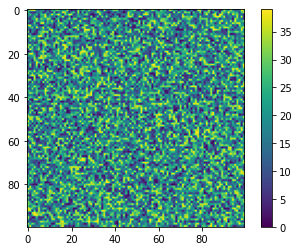

In [35]:
plt.imshow(dat)
plt.colorbar()
plt.show()